<a href="https://colab.research.google.com/github/drscotthawley/DLAIE/blob/main/2025/AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drscotthawley/DLAIE/blob/main/Lessons/16_VAE.ipynb)

# An Arsenal of Autoencoders: AE, VAE, Conditional VAE, VQ-VAE


## Outline:
1. Introduction
1. Setting Up
1. Autoencoder
1. Varational Autoencoder (VAE)
1. Conditional Variational Autoencoder (C-VAE)
1. Vector-Quantized Varational Autoencoder (VQ-VAE)

## Introduction

An autoencoder is a system that forces the input through some encoding "bottleneck" and then tries to reconstruct its input via it's decoding shape. The overall shape resembles and hourglass, and the encoded representation on the middle is often called a "latent space".  This naturally results in a kind of (lossy) compression, and thus it forces the network to learn a latent space representation of the important qualities of the data.

<img src="https://github.com/drscotthawley/DLAIE/blob/main/images/AutoEncoder.png?raw=true" height="300px">


Unlike the U-Net, which computes the change in something and uses skip connections, the goal of an autoencoder is to learn a *compressed represenatation* of the data (i.e., the data distribution or manifold) by training on the goal of *reconstructing its input*, and there are no skip connections. If we were to include skip connections, they would "shortcut" (pun intended) the process of learning the compressed representation.
(Note: skip connections within the Encoder or within the Decoder could be ok, but there should be nothing connecting the two main sections other than the latent space.)

Autoencoders have been used for a variety of things over the years:
- **Keep the Encoder, Don't Use the Decoder:** As an "unsupervised learning" method (i.e., no labels needed), you could *pre-train* an Encodeer that you want to use for some downstream task (such as classification) by training an autoencoder and keeping only the Encoder part.
- **Learnable Codecs:** For communication protocols such as streaming audio or video, transmitting signals only in the latent space can result in very high compression ratios compared to traditional (rules-based) compression schemes because the ML codec is adapted to the specific kind of data it will be used for. Examples: SoundStream, Lira, DAC,...
- **Keep the Decoder, Don't Use the Encoder:** For generative models, sometimes one really wants just the Decoder part, so that you can generate new data in (small) latent space, and decode it to something useful

There are various ways to do autoencoders and to stretch the idea of an autoencoder to new tasks.  We will look at a few here.
Depending on the use case, the **"kind" of latent space** you construct can have properties that make it more amenable to certain tasks than others.  

*NOTE: Sometimes the term "autoencoder" is applied even if the output is not intended to match the input, but perhaps instead to be a modified form of the input.  This is because of the *similarity of the architecture* for computing changes, however we will retain the use of "autoencoder" to mean something that reconstructs its input.*

# 2. Setup

## Setup Imports

For this lesson, let's try [Pytorch Lightning](https://lightning.ai/docs/pytorch/stable/) as an alternative to raw Pytorch. (One approach is neither better nor worse than the other, this is just done to expose you to different frameworks.)

In [2]:
# Uninstall Colab's bigframes because we don't care
%pip uninstall -y bigframes
# Install Lightning, also let's make sure "rich" progress bars are updates
%pip install -Uqq lightning wandb rich einops

Found existing installation: bigframes 2.21.0
Uninstalling bigframes-2.21.0:
  Successfully uninstalled bigframes-2.21.0


In [3]:
import torch
from torch import nn, optim, utils
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import RichProgressBar
import wandb
import numpy as np
from einops import rearrange

## Setup Dataset & DataLoaders

We'll use MNIST for this demo to keep things lightweight and simple

In [8]:
train_ds = MNIST(root='./data', train=True,  download=True, transform=ToTensor())
test_ds  = MNIST(root='./data', train=False, download=True, transform=ToTensor())
val_ds = test_ds  #alias val for test
print(f"Data set lengths: train: {len(train_ds)}, test: {len(test_ds)}")


batch_size = 64 # could make this bigger
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=2, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=2, shuffle=False)
val_dl = test_dl # alias val & test

Data set lengths: train: 60000, test: 10000


Inspect our data a bit..

y (target) = tensor([7, 3, 0, 0]) 
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 2: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 3: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0


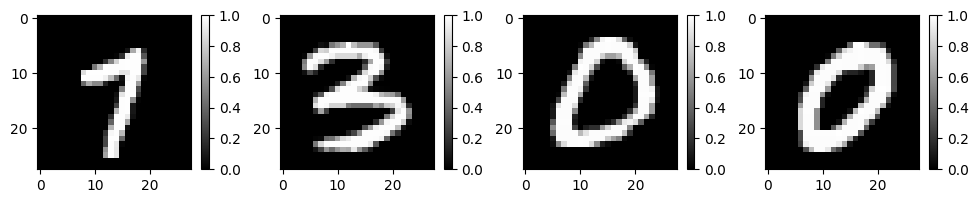

In [11]:
def show_xs(xs, show_stats=True):
    """Show one or more input images
    A little utility we'll call again & again to show one or more images"""
    if type(xs) is not list: xs = list(xs)
    ncols = len(xs)
    fig, axs = plt.subplots(figsize=(3*ncols,2), ncols=ncols, squeeze=False)
    ax = axs.ravel()
    for col, x in enumerate(xs):
        if len(x.shape)>2: x = x[0] # remove any batch dimension
        if show_stats:
            if ncols > 1: print(f"col {col}: ",end="")
            print(f"x.shape = {tuple(x.shape)}, min(x) = {torch.min(x)}, max(x) = {torch.max(x)}")
        digit = ax[col].imshow(x.detach().cpu().numpy(), cmap='gray')
        fig.colorbar(digit, ax=ax[col])
    plt.show()

x, y = next(iter(train_dl))   # pick a few elements from the dataset
print(f"y (target) = {y[:4]} ")

show_xs(x[:4])

Define dataloaders

# 3. Autoencoder (aka "Vanilla Autoencoder")


First we'll try a regular autoencoder.
For the encoder and decoder, we could use convolutional layers, but MNIST images are small enough that we can get by with using `Linear` layers.

In [ ]:
latent_dim = 3   # more = better reconstructions, but 3 we can plot!

n_hid = [256, 64]  # could imagine adding more layers

act = nn.LeakyReLU # works ok.

encoder = nn.Sequential(
                nn.Linear(28 * 28, n_hid[0]),
                act(),
                nn.Linear(n_hid[0], n_hid[1]),
                act(),
                nn.Linear(n_hid[1], latent_dim))

decoder = nn.Sequential(
                nn.Linear(latent_dim, n_hid[1]),
                act(),
                nn.Linear(n_hid[1], n_hid[0]),
                act(),
                nn.Linear(n_hid[0], 28 * 28),
                #nn.Sigmoid(),        # optional. we do want outputs on [0,1]
                )

use_conv=False

### Visualize the Reconstruction

Latents are z =  tensor([[0.0254, 0.0624, 0.0089]])
x.shape = (28, 28), min(x) = -0.21188227832317352, max(x) = 0.22752298414707184


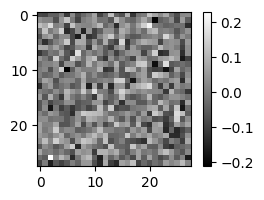

In [ ]:
# test the model, just to make sure we get no errors from mmult ops
# the result will look like random noise since the model is untrained right now
with torch.no_grad():
    x = x.view(x.size(0), -1)
    z = encoder(x)
    print("Latents are z = ",z)
    recon = decoder(z)
    recon = recon.view(x.size(0), 28, -1)
    show_xs(recon)

^^ That was with randomly initialized weights, so we expect a random image. This was just to test that the matrix multiplications work out right.

Now we'll define our AutoEncoder model.  In PyTorch Lightning, we package a few other operations within the model class, and we make it a subclass of `L.LightningModule`:

In [ ]:
# instead of nn.Module, we use L.LightningModule
class AEModel(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return z, x_hat

    # the __init__ and forward are the basic PyTorch functions
    # What follows are definitions used within the PyTorch Lightning training loop
    def do_pred(self, batch, batch_idx):
        x, y = batch
        if not use_conv:
            x = x.view(x.size(0), -1)  # flatten for input to our linear layer
        z, recon = self.forward(x)
        loss = nn.functional.mse_loss(recon, x)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.do_pred(batch, batch_idx)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.do_pred(batch, batch_idx)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

autoencoder = AEModel(encoder, decoder)
model = autoencoder  # alias

In [ ]:
wandb.login()

wandb: Currently logged in as: drscotthawley to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.finish()  # close any previous runs. ignore errors if not.
# Lightning defines its own WandbLogger callback...
wandb_logger = WandbLogger(log_model="all", project='ae_tut')
try:
    wandb_logger.watch(model)
except:
    pass

The following is our training loop.  It's like the "Learner" from fast.ai and encapsulates the basic training logic we've seen in previous lessons.

In [ ]:
epochs = 10
trainer = L.Trainer(max_epochs=epochs, devices="auto")# , callbacks=RichProgressBar(leave=True))
trainer.fit(model=autoencoder, train_dataloaders=train_dl, val_dataloaders=val_dl )
wandb.finish()

### Show Inference using the AutoEncoder

In [ ]:
@torch.no_grad()
def test_inference(model, idx=None):
    model.eval()
    """ Run input data through the (V)AE and plot the reconstruction."""
    if idx is None: idx = torch.randint( len(test_ds), (1,) )[0]  # grab random input
    x, y = test_ds[idx]
    if not use_conv:
        x = x.view(x.size(0), -1)

    recon = model.forward(x) # run the input thorugh the model and get the reconstruction
    recon = recon[-1]
    if not use_conv:
        recon = recon.view(x.size(0), -1)
    print("Latents z = ",z)
    recon = recon.view(x.size(0), 28, -1)
    x = x.view(x.size(0), 28, -1)
    show_xs([x,recon])  # plot original and recon

idx = 0
test_inference(autoencoder, idx=idx)

NameError: name 'torch' is not defined

Notice how output is blurry.  That's because it learned the mean.

# 3. Variational Autoencoder (VAE)

When one trains a vanilla autoencoder, the resulting latent space is *not* Gaussian, it's "lumpy" and yield *wild* results if you just try to randomly sample from points in latent space. In order to "regularize" the latent space and make it "smoother", we need to add an objective about what kind of latent space we want, and this is where the VAE comes in.

A VAE replaces single values in latent spaces with *pairs* of values: a *mean* and a standard deviation (or variance, which is just std dev squared). That is to say, it assumes that the latent space has a *normal* or *Gaussian* distribtuion.

![img](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*kXiln_TbF15oVg7AjcUEkQ.png)

*Image Source: Rushikesh Shende*

To use it as a "vanilla" autoencoder, one can just use the mean values, or to use it as a *generative model*, one can sample values assuming the Gaussian prior.


**The basic ideas:**

* we force the Decoder to decode points in latent space *nearby* to the point corresponding to the encoded image
* we 'scrunch' the latent space so it looks like a Gaussian

For the vanilla autoencoder, our loss was purely based on reconstruction. For the VAE,  we will add an extra (and somewhat *competing*) goal: to try to make the distribution of latent space approximately gaussian.   Because of these two goals, *the loss function will not be driven to zero*. Rather, it will be driven to an "equilibrium" between these two different forces (one pulling toward better reconstruction loss, the other toward gaussian-ness.)


> FUN FACT: We've been using Mean Squared Error for reconstruction loss up to this point, but for the VAE we need to use Binary Cross Entropy (aka Negative Log Likelihood, aka KL Divergence) because we're modeling the *probability distribution* of the outputs.  If we used MSE for reconstruction, we'd get only the mean of the distribution.

*NB: Here's a good detailed discussion of what's going on in VAEs: https://arxiv.org/abs/2006.10273*

### Define the VAE

In [ ]:
# encoder now spits out mean and variance
vae_encoder = nn.Sequential(
                nn.Linear(28 * 28, n_hid[0]),
                act(),
                nn.Linear(n_hid[0], n_hid[1]),
                act(),
                nn.Linear(n_hid[1], latent_dim*2), # *2 b/c mu, log_var
                )

# decoder is same as before
decoder = nn.Sequential(
                nn.Linear(latent_dim, n_hid[1]),
                act(),
                nn.Linear(n_hid[1], n_hid[0]),
                act(),
                nn.Linear(n_hid[0], 28 * 28),
                nn.Sigmoid(), # optional forcing to [0,1], so we can use BCE loss
                )

In [ ]:
# instead of nn.Module, we use L.LightningModule
class VAEModel(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparam_sample(self, mu, log_var):
        std = torch.exp(0.5*log_var).sqrt() # why the 0.5?
        noise = torch.randn_like(std)       # the "noise"
        return mu + std * noise

    def forward(self, x):
        z = self.encoder(x)
        i_half = z.shape[-1]//2
        mu, log_var = z[:,:i_half],  z[:,i_half:]
        z_hat = self.reparam_sample(mu, log_var)
        x_hat = self.decoder(z_hat)
        return z, mu, log_var, z_hat, x_hat

    def pred_and_log(self, batch, batch_idx, log_prefix=''):
        x, y = batch
        x = x.view(x.size(0), -1)  # flatten for linear layer
        z, mu, log_var, z_hat, x_hat = self.forward(x)

        #recon_loss = nn.functional.mse_loss(x_hat, x)
        recon_loss = nn.functional.binary_cross_entropy(x_hat, x) # remember you need a sigmoid on decoder out to use bce
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        scrunch_factor = 5e-4  # larger means blurrier/blobbier; rescale to get kl & recon similar
        rescaled_kl_loss = (kl_loss * scrunch_factor)
        loss = recon_loss + rescaled_kl_loss

        self.log(f'{log_prefix}loss', loss, prog_bar=True)
        self.log(f'{log_prefix}recon_loss', recon_loss)
        self.log(f'{log_prefix}kl_loss', kl_loss)
        self.log(F'{log_prefix}rescaled_kl_loss', rescaled_kl_loss)
        return loss

    def training_step(self, batch, batch_idx):
        return self.pred_and_log(batch, batch_idx, log_prefix='train/')

    def validation_step(self, batch, batch_idx):
        return self.pred_and_log(batch, batch_idx, log_prefix='val/')

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=5e-4)

    def on_epoch_start(self): # give us a new line for each epoch
        print('\n')

vae = VAEModel(vae_encoder, decoder)
model = vae

In [ ]:
wandb.finish()
wandb_logger = WandbLogger(log_model="all", project='vae_tut')
wandb_logger.watch(model) # this thing complains too much upon re-runs, just ignore it and keep going

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
epochs = 10
trainer = L.Trainer(max_epochs=epochs, devices="auto", logger=wandb_logger)# , callbacks=RichProgressBar())# leave=True))
trainer.fit(model=vae, train_dataloaders=train_dl, val_dataloaders=val_dl)
wandb.finish()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 217 K 
1 | decoder | Sequential | 218 K 
---------------------------------------
436 K     Trainable params
0         Non-trainable params
436 K     Total params
1.745     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train/kl_loss,▁▄▆▇▆▆▅▆█▇▆▅▆▆▆▅▆▇▇▅▆▆▆▅▅▆▆▆▇▆▆▆▅▅▅▆▆▅█▆
train/loss,█▅▅▄▃▃▄▃▂▂▃▃▂▃▃▃▂▂▁▁▃▂▁▂▂▂▁▂▁▂▂▁▁▂▂▂▁▁▂▁
train/recon_loss,█▅▅▄▂▃▄▃▂▂▃▃▂▃▃▃▂▂▁▁▃▂▁▂▂▂▁▂▁▂▂▁▁▂▂▂▁▁▂▁
train/rescaled_kl_loss,▁▄▆▇▆▆▅▆█▇▆▅▆▆▆▅▆▇▇▅▆▆▆▅▅▆▆▆▇▆▆▆▅▅▅▆▆▅█▆
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val/kl_loss,▁▇▄▂▂█▃▄▇▅
val/loss,█▆▄▄▃▂▂▂▁▁
val/recon_loss,█▆▄▄▃▂▂▂▁▁
val/rescaled_kl_loss,▁▇▄▂▂█▃▄▇▅
epoch,9


Doesn't seem like the loss is doing down as we train. Hmmm. Let's try some inference:

z =  tensor([[-0.0222, -0.0767,  0.0879]], grad_fn=<AddmmBackward0>)
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = 5.13603731863323e-19, max(x) = 0.9713922142982483


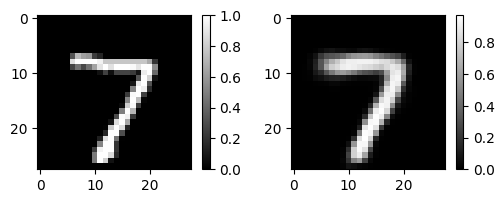

z =  tensor([[-0.0222, -0.0767,  0.0879]], grad_fn=<AddmmBackward0>)
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = 2.9167679556352244e-12, max(x) = 0.8784401416778564


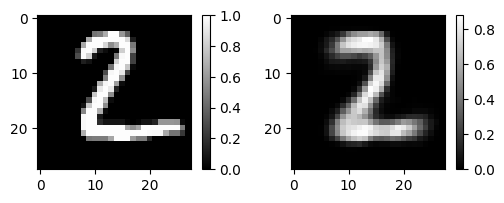

In [ ]:
test_inference(vae, idx=0)
test_inference(vae, idx=1)

Looks similar to the regular autoencoder, right?

Now let's try perturbing our input a bit

## Comparing the AE and VAE

Perturbing the regular autoencoder with strength = 5.0:


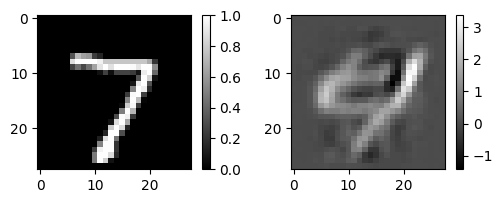

Perturbing the VAE with strength = 5.0:


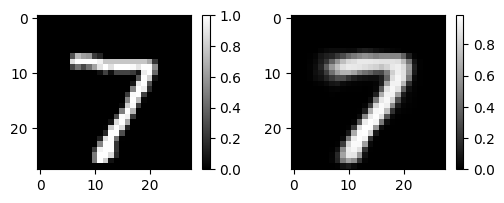

In [ ]:
@torch.no_grad()
def infer_perturb(model, idx=None, strength=1.0):
    "Another utility we'll use for running images through the (V)AE"
    if idx is None: idx = torch.randint( len(test_ds), (1,) )[0]
    x, y = test_ds[idx]
    z = model.encoder(x.view(x.size(0), -1))
    if z.shape[-1] > latent_dim: z = z[:,:latent_dim] # if VAE, just use the mean values
    z_hat = z + strength*torch.randn_like(z)
    x_hat = model.decoder(z_hat)
    x_hat = x_hat.view(x.size(0), 28, -1)
    show_xs([x,x_hat], show_stats=False)

idx=0
strength = 5.0
print(f"Perturbing the regular autoencoder with strength = {strength}:")
infer_perturb(autoencoder, idx=idx, strength=strength)
print(f"Perturbing the VAE with strength = {strength}:")
infer_perturb(vae, idx=idx, strength=1.0)

Depending on the random values you get, perturbations may cause the regular AE output to look like not-a-number, whereas the VAE output is probably more stable.

Note that without any final rescaling of outputs (e.g. via `nn.Sigmoid`), typically the output of the regular AE extends wayyy outside the [0,1] intensity bounds whereas the VAE's outputs are still properly bounded.


## Further Investigations: Add interpolation, 3D viz, more.

Make a grid of points in latent space and see what they decode to.

z_hat_batch.shape = torch.Size([225, 3])
grid.shape = torch.Size([3, 452, 452])


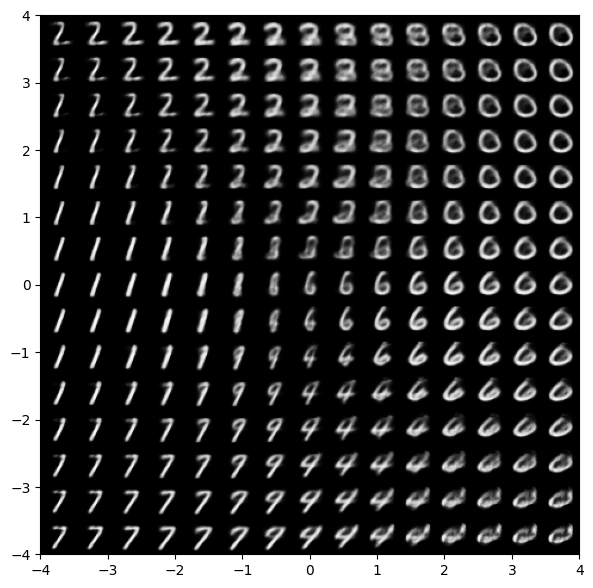

In [ ]:
def gen_grid(decoder, xmin=-4, xmax=4, nrow=15):
    zhats = []
    with torch.no_grad():
        for xcoord in torch.linspace(xmin,xmax,nrow):
            for ycoord in torch.linspace(xmin,xmax,nrow):
                z_hat = torch.tensor([xcoord,ycoord,0.0]) # interpolate in a plane
                zhats.append(z_hat)

        z_hat_batch = torch.vstack(zhats) # unsqueeze adds dummy color channel
        print("z_hat_batch.shape =",z_hat_batch.shape)
        x_hat = decoder(z_hat_batch)
        x_hat = x_hat.view(x_hat.size(0), 1, 28, 28)

    grid = torchvision.utils.make_grid(x_hat, nrow)
    print("grid.shape =",grid.shape)

    grid = rearrange(grid, 'c h w -> h w c')
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(grid.numpy(), extent=(xmin,xmax,xmin,xmax))
    plt.show()

gen_grid(decoder)


# 4. Conditional VAE, i.e. Adding Controls to the VAE


"Conditioning" means attaching controls to the model that, via training, it can learn to associate with specific kinds outputs. For example, we could do "class conditioning" where we tell it what class --- in our case, which digit -- we want the output to be.

The conditioning may take the form of adding or multiplying numbers to the activations, concatenating some controls,...lots of things. One general class of conditioning methods is often referred to as [FiLM layers](https://distill.pub/2018/feature-wise-transformations/), where FiLM stands for **F**eature-w**i**se **L**inear **M**odulation. Essentially it means we will apply our conditioning by both addition and multiplication.

How and where we apply the conditioning is up to us: we could apply it to the encoder, the latent space, and/or the decoder. We could include the conditioning signal in only one spot, or in between all layers. ...It kind of depends on what we want to do.  

We'll take a clue from [StyleGAN2](https://arxiv.org/abs/1912.04958v2) (even though it's a GAN!) and apply our conditioning all throughout the model.

> TODO: Draw a diagram!

In [ ]:
# Here's one way to make a FiLM layer
class FiLM(nn.Module):
    def __init__(self, x_dim, cond_dim):
        super().__init__()
        self.gamma_gen = nn.Linear(cond_dim, x_dim)
        self.beta_gen  = nn.Linear(cond_dim, x_dim)

    def forward(self, x, cond):
        gamma = self.gamma_gen(cond)
        beta  = self.beta_gen(cond)
        return x * gamma + beta

We could do a conditional "regular autoencoder" but it would be kind of boring because whichever digit you ask for, say a 7, it'll just produce the exact same 7 every time.  We want some *variation* to the outputs, so let's make a conditional VAE

In [ ]:
# Conditional VAE

latent_dim = 4

n_hid = [256, 64]  # could imagine adding more layers

act = nn.GELU # this is popular in many models

# should we condition the encoder too?
# doing so may help give structure to the latent space
vae_encoder = nn.Sequential(    # same as before
                nn.Linear(28 * 28, n_hid[0]),
                act(),
                nn.Linear(n_hid[0], n_hid[1]),
                act(),
                nn.Linear(n_hid[1], 2*latent_dim),
                )

cond_dim = 10  # we'll use one-hot encoding for class conditioning; 10 classes


class EncoderCond(nn.Module):
    def __init__(self, latent_dim, n_hid, cond_dim):
        super().__init__()
        self.l1 = nn.Linear(28*28, n_hid[0])
        self.f1 = FiLM(n_hid[0], cond_dim)
        self.l2 = nn.Linear(n_hid[0], n_hid[1])
        self.f2 = FiLM(n_hid[1], cond_dim)
        self.l3 = nn.Linear(n_hid[1], 2*latent_dim)
        self.act = act()
    def forward(self, x, cond, debug=False):
        x = self.act( self.l1(x) )
        x = self.f1(x,cond)
        x = self.act( self.l2(x) )
        x = self.f2(x, cond)
        x = self.l3(x)
        if debug: print("leaving Encoder, x.shape =",x.shape)
        return x

# Let's try sticking a FiLM before each Linear layer in the Decoder.
# Oh, for the decoder we can't just use nn.Sequential anymore...
class DecoderCond(nn.Module):
    def __init__(self, latent_dim, n_hid, cond_dim):
        super().__init__()
        self.f1 = FiLM(latent_dim, cond_dim)
        self.l1 = nn.Linear(latent_dim, n_hid[1])
        self.f2 = FiLM(n_hid[1], cond_dim)
        self.l2 = nn.Linear(n_hid[1], n_hid[0])
        self.f3 = FiLM(n_hid[0], cond_dim)
        self.l3 = nn.Linear(n_hid[0], 28 * 28)
        self.act = act()

    def forward(self, x, cond, debug=False):
        if debug: print("Debug: 1 x.shape =",x.shape)
        x = self.f1(x, cond)
        x = self.act( self.l1(x) )
        x = self.f2(x, cond)
        x = self.act( self.l2( x ) )
        x = self.f3(x, cond)
        x = self.l3( x )
        x = torch.sigmoid(x) # needed if you want to use BCE loss
        return x

In [ ]:
# instead of nn.Module, we use L.LightningModule
class CondVAEModel(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.ema_loss = 0.06

    def reparam_sample(self, mu, log_var):
        std = torch.exp(0.5*log_var).sqrt() # why the 0.5?
        noise = torch.randn_like(std)       # the "noise"
        return mu + std * noise

    def forward(self, x, cond):
        z = self.encoder(x, cond)
        i_half = z.shape[-1]//2
        mu, log_var = z[:,:i_half],  z[:,i_half:]
        z_hat = self.reparam_sample(mu, log_var)
        x_hat = self.decoder(z_hat, cond)
        return z, mu, log_var, z_hat, x_hat

    def gen(self, y, n_gen=1):
        mu = 4*torch.randn((n_gen, latent_dim))
        log_var = 2*torch.randn((n_gen, latent_dim))
        z_hat = self.reparam_sample(mu, log_var)
        cond = F.one_hot(torch.tensor(y), num_classes=10).float()
        x_hat = self.decoder(z_hat, cond)
        return x_hat

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)  # flatten for linear layer
        cond = F.one_hot(y, num_classes=10).float().to(x.device) # pass in the desired output class as cond

        x_targ, cond_targ = x, cond  # ordinary cond-vae
        use_mixup = False   # mixup seems to 'confuse' the c-vae, makes things blurry.  nah
        if use_mixup:
            cond_strength = torch.rand((1)).to(x.device)
            # draw x2, y2 values from elsewhere in the batch
            rand_inds = torch.randperm(x.size()[0])
            x2, y2 = x[rand_inds], y[rand_inds]
            x2 = x2.view(x.size(0), -1)
            cond2 = F.one_hot(y2, num_classes=10).float().to(x.device)
            # target is between x and x2, determined by cond_strength
            x_targ    = torch.lerp(x,    x2,    cond_strength)
            cond_targ = torch.lerp(cond, cond2, cond_strength)

        z, mu, log_var, z_hat, x_hat = self.forward(x, cond_targ)

        #recon_loss = nn.functional.mse_loss(x_hat, x_targ)   # mse loss (with no sigmoid on decoder output) destroys variation!
        recon_loss = nn.functional.binary_cross_entropy(x_hat, x_targ) # remember you need a sigmoid on decoder out to use bce

        scrunch_factor = 0.001
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + (kl_loss * scrunch_factor)
        with torch.no_grad():
            self.ema_loss = 0.99*self.ema_loss + 0.01*loss.detach().item()
            self.log('ema_loss', self.ema_loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

In [ ]:
vae_encoder_cond = EncoderCond(latent_dim, n_hid, cond_dim)
vae_decoder_cond = DecoderCond(latent_dim, n_hid, cond_dim)
cond_vae = CondVAEModel(vae_encoder_cond, vae_decoder_cond)

epochs = 10
trainer = L.Trainer(max_epochs=epochs, devices="auto")
trainer.fit(model=cond_vae, train_dataloaders=train_dl)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/shawley/envs/dlaie/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Let's take a look at inference:

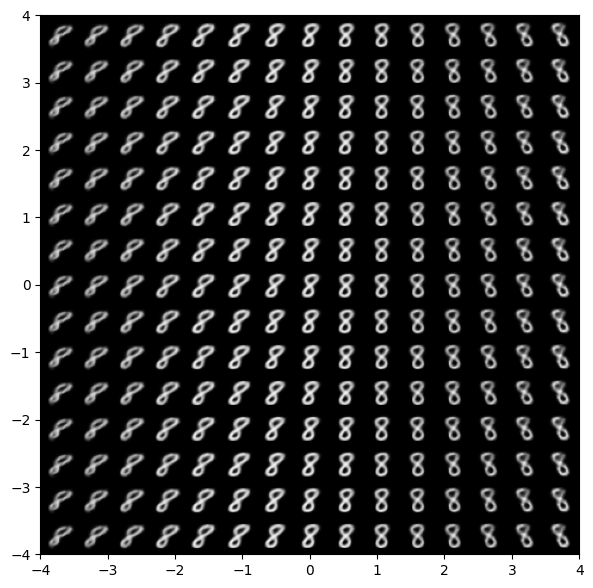

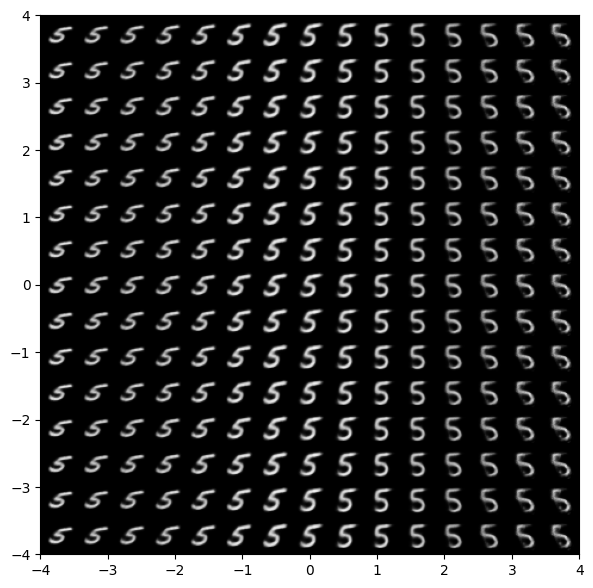

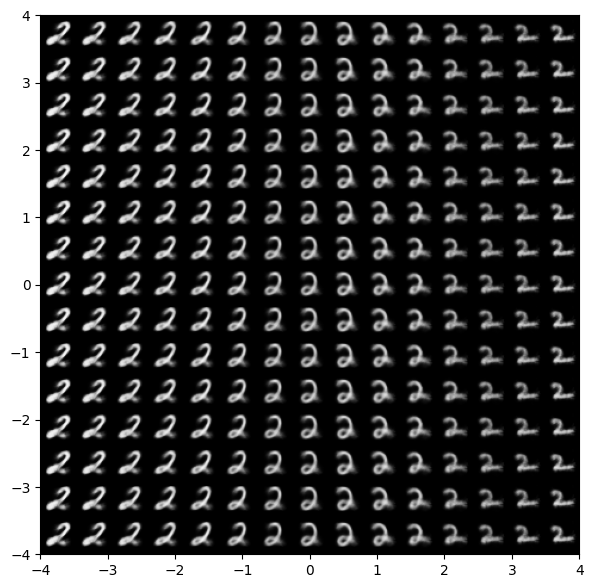

In [ ]:
def cond_grid(y):
    cond = F.one_hot(torch.tensor(y), num_classes=10).float()
    nrow = 15
    xmin, xmax = -4,4
    zhats = []
    with torch.no_grad():
        for xcoord in torch.linspace(xmin,xmax,nrow):
            for ycoord in torch.linspace(xmin,xmax,nrow):
                z_hat = torch.tensor([xcoord,ycoord,0.0,0.0])#.to(device)
                zhats.append(z_hat)

        z_hat_batch = torch.vstack(zhats).unsqueeze(1) # unsqueeze adds dummy color channel
        x_hat = vae_decoder_cond(z_hat_batch, cond)
        x_hat = x_hat.view(x_hat.size(0), 1, 28, 28)

    grid = torchvision.utils.make_grid(x_hat, nrow)
    #print("grid.shape =",grid.shape)
    grid = rearrange(grid, 'c h w -> h w c')
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(grid.numpy(), extent=(xmin,xmax,xmin,xmax))
    plt.show()

cond_grid(8)
cond_grid(5)
cond_grid(2)

So we see that the latent space we used previously becomes entirely occupied by the digit we condition on, but we get different "properties" of that digit such as tilt, boldness, "font", etc. In other words, *translations in latent space amount to changes in style!*

# -- Stop Here ---

# Appendix: Vector Quantized VAE (VQ-VAE)
*2025: I don't know if we'll need to learn the VQVAE or not this semester. That's why it's an "appendix".*

# Appendix: Vector Quantized VAE (VQ-VAE)
*2025: I don't know if we'll need to learn the VQVAE or not this semester. That's why it's an "appendix".

> Point of Order: I think they should drop the second "V" from "VQ-VAE": in no sense is it variational. It is *not* a VAE, rather it is a VQ-*AE*: it is an autoencoder for which, during training, points in latent space are replaced by their nearest "codebook" vecotors, i.e. it will deterministically "snap" encoded latent point to the nearest codebook vector, and deterministically reconstruct from that. BTW, this determinism is why the loss for VQ-VAE is MSE, not BCE! During inference for generation, you *can* give it non-codebook latent points; the results will look a lot like the codebook values though!

For the VAE, we forced the distribution of points in latent space (what the smart people call the "prior" distribution, though some of us see this a "posterior" distribution since it's derived from the data, but I digress) was fixed to be a multidimensional gaussian.

But, maybe we want something a little more flexible than that. Another way to enforce a tractable probability distribution (i.e. besides assuming it's gaussian) is to quantize it.  So that's what we're going to do. We're basically going to try to cluster points -- "vectors" -- around a finite number of "codebook vectors".  Think of the codebook vectors as "team captains" or "tribal chieftans".  Eventually we'll start using the codebook vectors as "stand-ins" (i.e proxies, i.e.,....some theological term...) for the vectors in their vicinity. Doing so will form the "quantization" we're after. It will be an approximation, but hopefully it'll be so good you won't even notice. If you want to get into it, see the first part of [my blog post on Residual Vector Quantization](https://drscotthawley.github.io/blog/posts/2023-06-12-RVQ.html), which starts by talking about regular VQ.

The trick is going to be handling the quantization in a way that's *differentiable*. You might think "differential quantization" sounds like an oxymoron, and you'd be right. ;-) But there's a cheap workaround that works amazingly well.

What's going to happen is, when we encode into latent space, we'll replace the point with the *index that points to* the nearest vector in the codebook.  And we'll allow the codebook to evolve as we train.  Note that "nearest to" implies a nearest-neighbor algorithm, which can be slow, but we'll only be using it between one batch of z's at a time and our limited set of codebook vectors.


## Code
(Best if you just install Lucidrains' [`vector-quantize-pytorch`](https://github.com/lucidrains/vector-quantize-pytorch/blob/146810e271f435daa3834edd9473be050bc04647/vector_quantize_pytorch/vector_quantize_pytorch.py) package instead of my code. ;-) I'm kidding. )

The encoder and decoder will look a lot like our earlier VAE, but the stuff in the middle will change

In [ ]:
latent_dim = 2 # we'll use 2 for this just because I want to make sure the 'grid' images we make are easily interpretable

n_hid = [256, 64, 16]  # could imagine adding more layers

act = nn.LeakyReLU # works ok.


encoder = nn.Sequential(
                nn.Linear(28 * 28, n_hid[0]),
                nn.BatchNorm1d(n_hid[0]),  # Adding BatchNorm doesn't really help much tbh, you could take it out.
                act(),
                nn.Linear(n_hid[0], n_hid[1]),
                nn.BatchNorm1d(n_hid[1]),
                act(),
                nn.Linear(n_hid[1], n_hid[-1]),
                nn.BatchNorm1d(n_hid[-1]),
                act(),
                nn.Linear(n_hid[-1], latent_dim), # no more mu/log_var b/c it's not a gaussian
                )

# decoder is same as before
decoder = nn.Sequential(
                nn.Linear(latent_dim, n_hid[-1]),
                nn.BatchNorm1d(n_hid[-1]),
                act(),
                nn.Linear(n_hid[-1], n_hid[1]),
                nn.BatchNorm1d(n_hid[1]),
                act(),
                nn.Linear(n_hid[1], n_hid[0]),
                nn.BatchNorm1d(n_hid[0]),
                act(),
                nn.Linear(n_hid[0], 28 * 28),
                nn.Sigmoid(), # optional forcing to [0,1]
                )


class VQVAEModel(L.LightningModule):
    def __init__(self, encoder, decoder, cb_len=100):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.cb_len = cb_len  # codebook length, e.g. # of classes, or more
        self.cb = nn.Embedding(cb_len, latent_dim) # just a Parameter + random initialization. use .weight for values
        # Note: in practice one sees people initializing the codebook self.cb via K-means, but...we're not gonna

    def get_nearest_cbv(self, z):
        "get nearest codebook vectors"
        dist = torch.cdist(z, self.cb.weight)
        idx_q = torch.argmin(dist, dim=-1)
        z_q = self.cb.weight[idx_q]
        return z_q

    def forward(self,x):
        z = self.encoder(x)
        z_q = self.get_nearest_cbv(z)
        z_q_d = z + (z_q - z).detach()    # straight-through estimation; use only to pass to decoder
        x_hat = self.decoder(z_q_d)
        return z, z_q, x_hat

    def pred_and_log(self, batch, batch_idx, log_prefix=''):
        x, y = batch
        x = x.view(x.size(0), -1)
        z, z_q, x_hat = self.forward(x)

        recon_loss = 2*F.mse_loss(x_hat, x)
        cb_loss   = 0.5*F.mse_loss(z.detach(), z_q)
        beta = 0.1
        comm_loss = F.mse_loss(z,          z_q.detach())  * beta
        loss = recon_loss + cb_loss + comm_loss

        self.log(f'{log_prefix}loss', loss, prog_bar=True)
        self.log(f'{log_prefix}recon_loss', recon_loss)
        self.log(F'{log_prefix}cb_loss', cb_loss)
        self.log(F'{log_prefix}comm_loss', comm_loss)
        #print("self.cb.weight = ",self.cb.weight.cpu().detach().numpy())

        return loss

    def training_step(self, batch, batch_idx):
       return self.pred_and_log(batch, batch_idx, log_prefix='train/')


    def validation_step(self, batch, batch_idx):
        return self.pred_and_log(batch, batch_idx, log_prefix='val/')

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=5e-3)


vqvae = VQVAEModel(encoder, decoder)
model = vqvae

In [ ]:
wandb.finish()
wandb_logger = WandbLogger(log_model="all", project='vqvae_tut')
try:
    wandb_logger.watch(model) # this thing complains too much upon re-runs, just ignore it and keep going
except:
    pass

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
epochs = 10
trainer = L.Trainer(max_epochs=epochs, devices="auto", logger=wandb_logger)
trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)
wandb.finish()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 219 K 
1 | decoder | Sequential | 219 K 
2 | cb      | Embedding  | 200   
---------------------------------------
439 K     Trainable params
0         Non-trainable params
439 K     Total params
1.757     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train/cb_loss,▁▂▂▂▂▂▂▃▂▃▄▅▄▃▅▄▅▄▇▄▆▄█▄▇▄▅▆▆▅▆▆▅▆▆▅▅█▇▆
train/comm_loss,▁▂▂▂▂▂▂▃▂▃▄▅▄▃▅▄▅▄▇▄▆▄█▄▇▄▅▆▆▅▆▆▅▆▆▅▅█▇▆
train/loss,▆▆▄▃▁▂▅▃▃▁▃▆▄▁▆▆▄▄▅▃▅▄█▄▅▃▅▅▅▄▆▆▅▄▃▃▆▆▆▄
train/recon_loss,██▆▄▂▃▆▄▃▁▃▆▄▁▆▇▃▄▃▃▄▄▇▄▃▃▄▃▅▃▆▅▄▂▂▂▅▄▄▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val/cb_loss,▁▂▅▆▇▇████
val/comm_loss,▁▂▅▆▇▇████
val/loss,▄▁▃▃▄▅█▅▄▅
val/recon_loss,█▅▄▂▂▂▃▂▁▁
epoch,9


z, z_q = [array([[2.3298945 , 0.03771019]], dtype=float32), array([[2.2373638 , 0.28213897]], dtype=float32)]
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = 0.00024289196880999953, max(x) = 0.897861123085022


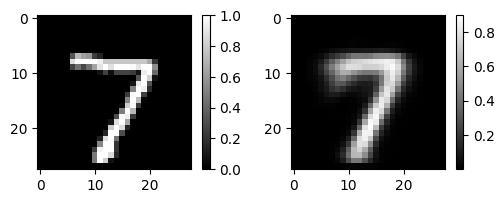

z, z_q = [array([[-0.03379813,  0.42790335]], dtype=float32), array([[0.14202751, 0.6230321 ]], dtype=float32)]
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = 0.0015031462535262108, max(x) = 0.7535026669502258


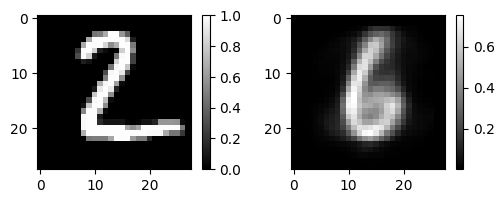

In [ ]:
# redo it
@torch.no_grad()
def test_inference2(model, idx=None):
    model.eval()
    "Another utility we'll use for running images through the (V)AE"
    if idx is None: idx = torch.randint( len(test_ds), (1,) )[0]
    x, y = test_ds[idx]
    x = x.view(x.size(0), -1)
    z, z_q, x_hat = model.forward(x)
    print("z, z_q =",[g.detach().cpu().numpy() for g in [z, z_q]])
    x_hat = x_hat.view(x.size(0), 28, -1)
    x = x.view(x.size(0), 28, -1)
    show_xs([x,x_hat])

test_inference2(vqvae, idx=0)
test_inference2(vqvae, idx=1)

Let's do the "grid of interpolation" thing again, only let's also show the locations (projected on to the plane) of the nearest codebook vectors for each point on our "interpolation grid".

We'll show the difference between what happens when you decode from "any" location in the latent space, vs. what happens if you "quantize" those locations first by filling in codebook vector values: Not alot!  That's because our activation functions are piecewise-linear, so the values set at the codebook vector locations get applied throughout the "region" regardless of whether you quantize or not.

z_batch.shape = torch.Size([81, 2])
cell_size= 1.0


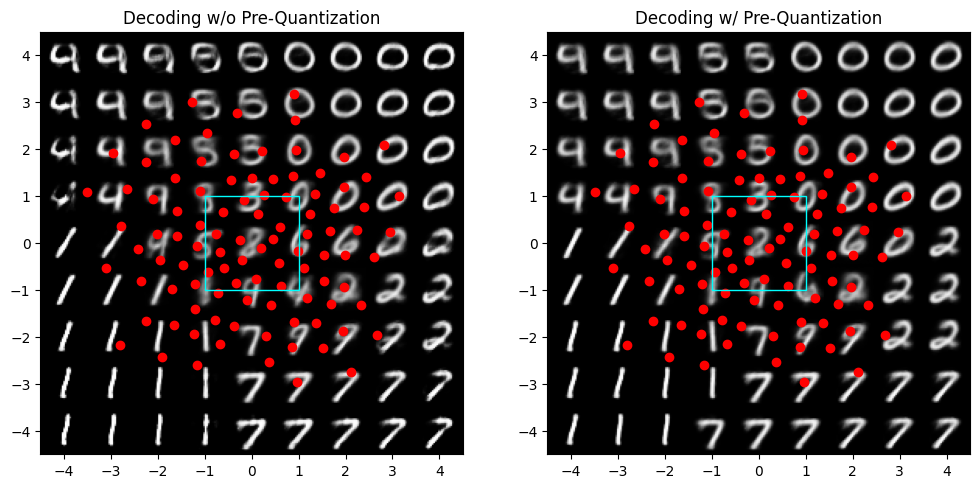

In [ ]:
import matplotlib.patches as patches
from scipy.spatial import Voronoi, voronoi_plot_2d


@torch.no_grad()
def gen_grid2(model, xmin=-4, xmax=4, nrow=9):
    zs = []
    for xcoord in torch.linspace(xmin,xmax,nrow):
        for ycoord in torch.linspace(xmin,xmax,nrow):
            #print("xcoord, ycoord =", xcoord, ycoord)
            z = torch.tensor([xcoord,ycoord]+[0]*(latent_dim-2)) # interpolate in a plane # points to encode
            zs.append(z)

    z_batch = torch.vstack(zs) # unsqueeze adds dummy color channel
    print("z_batch.shape =",z_batch.shape)
    nearest_cbvs = vqvae.get_nearest_cbv(z_batch)
    x_hat = vqvae.decoder(z_batch)
    x_hat = x_hat.view(x_hat.size(0), 1, 28, 28)

    x_hat_cbvs = vqvae.decoder(nearest_cbvs).view(x_hat.size(0), 1, 28, 28)

    # ahhhh we have to line up the MIDDLE of each little image with its coordinate value, so subtract & add half a 'grid cell'
    cell_size = (xmax-xmin)/(nrow-1)
    print('cell_size=',cell_size)
    xmin = xmin - cell_size/2
    xmax = xmax + cell_size/2

    fig, ax = plt.subplots(figsize=(12,6), ncols=2)
    for i, recon in enumerate([x_hat, x_hat_cbvs]):
        grid = torchvision.utils.make_grid(recon, nrow)
        grid = rearrange(grid, 'c h w -> h w c')
        ax[0].title.set_text('Decoding w/o Pre-Quantization')
        ax[1].title.set_text('Decoding w/ Pre-Quantization')

        ax[i].imshow(grid.numpy(), extent=(xmin,xmax,xmin,xmax))

        # superimpose  codebook vectors onto the image
        ax[i].scatter(model.cb.weight[:,0],model.cb.weight[:,1],c='r')
        # TODO: add Vornonoi cells?
        #vor = Voronoi(np.vstack((df.iloc[i, ::2], df.iloc[i, 1::2])).T)

        # add cyan box of where we're about to zoom to
        rect = patches.Rectangle((-1, -1), 2, 2, linewidth=1, edgecolor='cyan', facecolor='none')
        ax[i].add_patch(rect)

        ax[i].set_xlim(xmin,xmax)
        ax[i].set_ylim(xmin,xmax)
    plt.show()


gen_grid2(vqvae, xmin=-4,xmax=4)

Comparing the images on the right and left, we see that they're similar but not exactly the same.

That's a bit of a jumble, so let's "zoom in" to the box shown in the middle of the above picture:

z_batch.shape = torch.Size([81, 2])
cell_size= 0.25


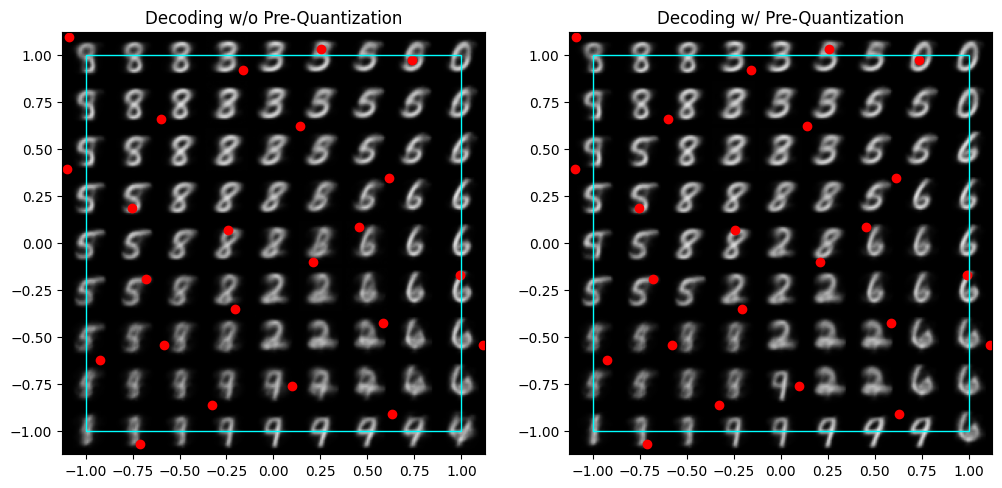

In [ ]:
gen_grid2(vqvae, xmin=-1, xmax=1)

....uh, seems like the red dots *should* appear in the *middle* of each region, but they more often appear at the boundaries between regions.  Not sure why that is.

TODO: figure out display of locations of dots

## For further investigation:
- VQ-VAE dictionary updates with Exponential Moving Averages